In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras.optimizers import Adam
import os

# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

def preprocess_data(csv_file, sequence_length=10):
    if not os.path.exists(csv_file):
        print(f"File not found: {csv_file}")
        return None, None, None, None, None, None

    dataset = pd.read_csv(csv_file)
    features = ['terminal_voltage', 'terminal_current', 'temperature', 
                'charge_current', 'charge_voltage', 'time', 'capacity', 'cycle']
    target = 'SOH'
    
    # Ensure necessary columns exist
    if target not in dataset.columns:
        # Calculate SOH if missing (assuming capacity is present and initial capacity is known)
        # But here we assume SOH column exists as per visual inspection of previous notebook
        pass 

    dataset = dataset[features + [target]].groupby('cycle', as_index=False).mean()

    # Split into train/test (Last 20% or 20 cycles)
    test_size = 20 if len(dataset) < 100 else int(len(dataset) * 0.2)
    split_idx = len(dataset) - test_size
    
    data_train = dataset.iloc[:split_idx].reset_index(drop=True)
    data_test = dataset.iloc[split_idx:].reset_index(drop=True)

    true_initial_cap = dataset['capacity'].iloc[0]

    sc = MinMaxScaler(feature_range=(0, 1))
    # Fit on ALL features including target
    scaled_train = sc.fit_transform(data_train[features + [target]])
    scaled_test = sc.transform(data_test[features + [target]])

    def create_seq(data):
        X, y = [], []
        for i in range(sequence_length, len(data)):
            X.append(data[i-sequence_length:i, :]) 
            y.append(data[i, -1]) # SOH is the last column
        return np.array(X), np.array(y)

    X_train, y_train = create_seq(scaled_train)
    X_test, y_test = create_seq(scaled_test)

    return X_train, y_train, sc, X_test, y_test, true_initial_cap

print("Preprocessing functions defined.")


2026-02-03 09:28:19.118198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770078499.136614   41953 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770078499.142614   41953 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770078499.155818   41953 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770078499.155838   41953 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770078499.155840   41953 computation_placer.cc:177] computation placer alr

Preprocessing functions defined.


In [2]:

def create_model(input_shape):
    model = Sequential()
    # Using GRU as seen in previous attempts or standard for time series
    model.add(GRU(60, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(60))
    model.add(Dropout(0.2))
    model.add(Dense(1)) # Predict SOH
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

class FLClient:
    def __init__(self, client_id, csv_file, sequence_length=10):
        self.client_id = client_id
        self.csv_file = csv_file
        self.X_train, self.y_train, self.sc, self.X_test, self.y_test, self.init_cap = preprocess_data(csv_file, sequence_length)
        if self.X_train is not None:
            self.n_samples = len(self.X_train)
            print(f"Client {client_id} ({csv_file}): Train data shape {self.X_train.shape}")
        else:
            self.n_samples = 0
            print(f"Client {client_id}: Failed to load data")

    def train(self, global_weights, epochs=5, batch_size=32):
        if self.n_samples == 0:
            return global_weights, 0, 0
            
        model = create_model((self.X_train.shape[1], self.X_train.shape[2]))
        model.set_weights(global_weights)
        
        # Train locally
        history = model.fit(self.X_train, self.y_train, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            verbose=0)
        
        # Return updated weights, number of samples, and last loss
        return model.get_weights(), self.n_samples, history.history['loss'][-1]

    def evaluate(self, global_weights):
        if self.n_samples == 0:
            return 0
        model = create_model((self.X_test.shape[1], self.X_test.shape[2]))
        model.set_weights(global_weights)
        loss = model.evaluate(self.X_test, self.y_test, verbose=0)
        return loss

class FLServer:
    def __init__(self, clients, input_shape):
        self.clients = clients
        self.global_model = create_model(input_shape)
        self.global_weights = self.global_model.get_weights()
        self.round_losses = []

    def aggregate_weights(self, client_weights_and_sizes):
        # Weighted Average (FedAvg)
        new_weights = []
        total_size = sum([size for _, size in client_weights_and_sizes])
        
        # Initialize with zeros of correct shape
        for w in self.global_weights:
            new_weights.append(np.zeros_like(w))
            
        for weights, size in client_weights_and_sizes:
            ratio = size / total_size
            for i in range(len(new_weights)):
                new_weights[i] += weights[i] * ratio
                
        return new_weights

    def train_round(self, round_num, local_epochs=5):
        print(f"--- Round {round_num} ---")
        client_updates = []
        
        # 1. Distribute weights and train clients
        for client in self.clients:
            updated_weights, num_samples, loss = client.train(self.global_weights, epochs=local_epochs)
            client_updates.append((updated_weights, num_samples))
            print(f"  Client {client.client_id} loss: {loss:.6f}")
            
        # 2. Aggregate
        self.global_weights = self.aggregate_weights(client_updates)
        self.global_model.set_weights(self.global_weights)
        
        # 3. Evaluate Global Model on all clients (Average Test Loss)
        total_test_loss = 0
        for client in self.clients:
            total_test_loss += client.evaluate(self.global_weights)
        avg_test_loss = total_test_loss / len(self.clients)
        self.round_losses.append(avg_test_loss)
        print(f"  Global Test Loss: {avg_test_loss:.6f}")

print("FL Classes defined.")


FL Classes defined.


In [3]:

# Configuration
csv_files = [
    'DATA/B48_discharge_soh.csv', 
    'DATA/B33_discharge_soh.csv', 
    'DATA/B05_discharge_soh.csv'
]
clients = []

# Initialize Clients
# We need to know input shape first, so we use the first client to determine it
temp_X, _, _, _, _, _ = preprocess_data(csv_files[0])
input_shape = (temp_X.shape[1], temp_X.shape[2])

for i, f in enumerate(csv_files):
    client = FLClient(client_id=i+1, csv_file=f)
    if client.n_samples > 0:
        clients.append(client)

# Initialize Server
server = FLServer(clients, input_shape)

# Run Federated Learning
N_ROUNDS = 20
LOCAL_EPOCHS = 5

for r in range(1, N_ROUNDS + 1):
    server.train_round(r, local_epochs=LOCAL_EPOCHS)

print("\nFederated Learning Completed.")


Client 1 (DATA/B48_discharge_soh.csv): Train data shape (38, 10, 9)
Client 2 (DATA/B33_discharge_soh.csv): Train data shape (133, 10, 9)
Client 3 (DATA/B05_discharge_soh.csv): Train data shape (125, 10, 9)


I0000 00:00:1770078501.553333   41953 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21731 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:27:00.0, compute capability: 8.6
/home/mulder/tools/anaconda/envs/tf_gpu/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- Round 1 ---


I0000 00:00:1770078504.667858   42027 cuda_dnn.cc:529] Loaded cuDNN version 91002


  Client 1 loss: 0.015362
  Client 2 loss: 0.016964
  Client 3 loss: 0.031420
  Global Test Loss: 0.022838
--- Round 2 ---
  Client 1 loss: 0.008183
  Client 2 loss: 0.013099
  Client 3 loss: 0.008267
  Global Test Loss: 0.014635
--- Round 3 ---
  Client 1 loss: 0.010537
  Client 2 loss: 0.009576
  Client 3 loss: 0.007264
  Global Test Loss: 0.017901
--- Round 4 ---
  Client 1 loss: 0.008436
  Client 2 loss: 0.009901
  Client 3 loss: 0.006275
  Global Test Loss: 0.023620
--- Round 5 ---
  Client 1 loss: 0.011080
  Client 2 loss: 0.011324
  Client 3 loss: 0.005584
  Global Test Loss: 0.015833
--- Round 6 ---
  Client 1 loss: 0.005750
  Client 2 loss: 0.008989
  Client 3 loss: 0.007351
  Global Test Loss: 0.024380
--- Round 7 ---
  Client 1 loss: 0.007295
  Client 2 loss: 0.009514
  Client 3 loss: 0.005484
  Global Test Loss: 0.024049
--- Round 8 ---
  Client 1 loss: 0.004632
  Client 2 loss: 0.008772
  Client 3 loss: 0.003887
  Global Test Loss: 0.013663
--- Round 9 ---
  Client 1 loss:

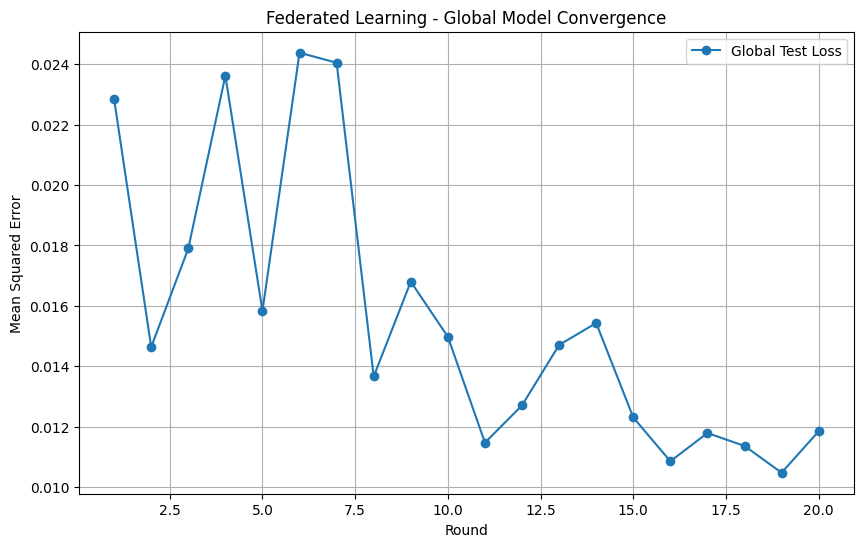


--- Fine-Tuning for Client 1 (B48) ---
Training for 10 additional epochs on local data...
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0101
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0073
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0056
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0060
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0047
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0083
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0061
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0050
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0049
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0045
Fine-tuning completed.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Client 1 (B48) - Global Model (Before Fine-Tuning)
  MSE: 0.000759
  RMSE: 0.027542


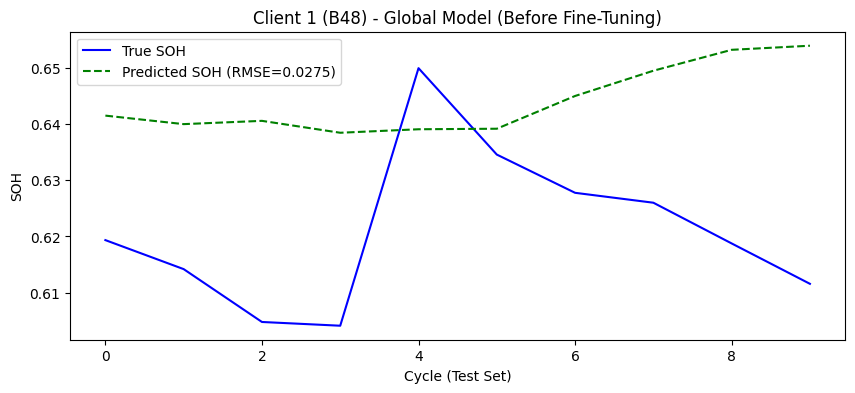

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Client 1 (B48) - Personalized Model (After Fine-Tuning)
  MSE: 0.000252
  RMSE: 0.015883


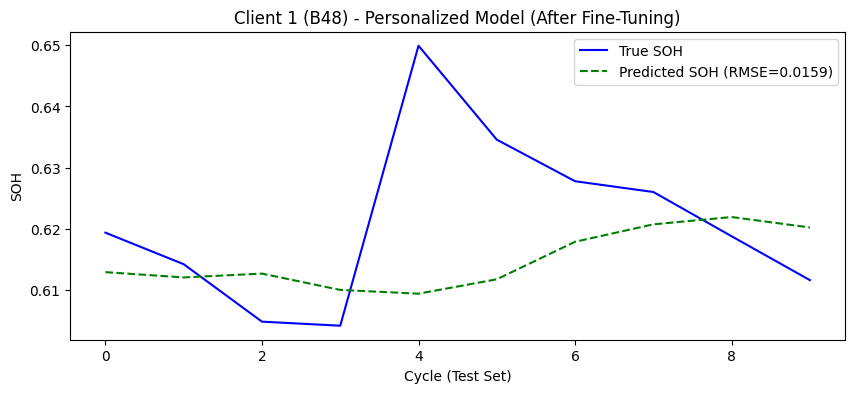

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


/home/mulder/tools/anaconda/envs/tf_gpu/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Client 2 (Battery DATA/B33_discharge_soh.csv) - Global Model
  MSE: 0.000191
  RMSE: 0.013811


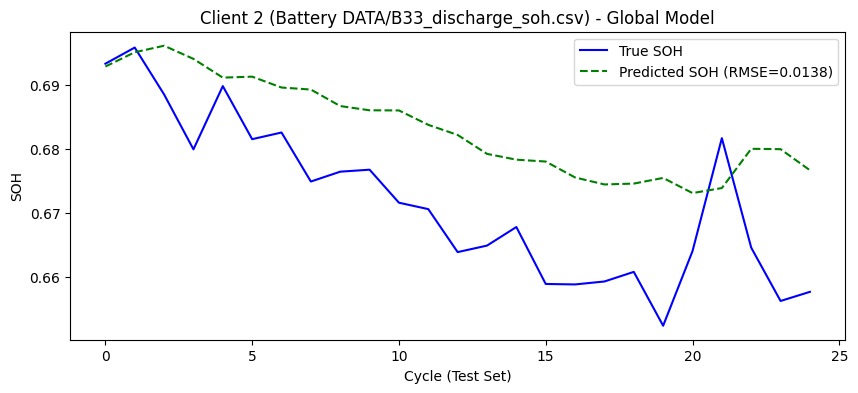

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

/home/mulder/tools/anaconda/envs/tf_gpu/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Client 3 (Battery DATA/B05_discharge_soh.csv) - Global Model
  MSE: 0.000038
  RMSE: 0.006176


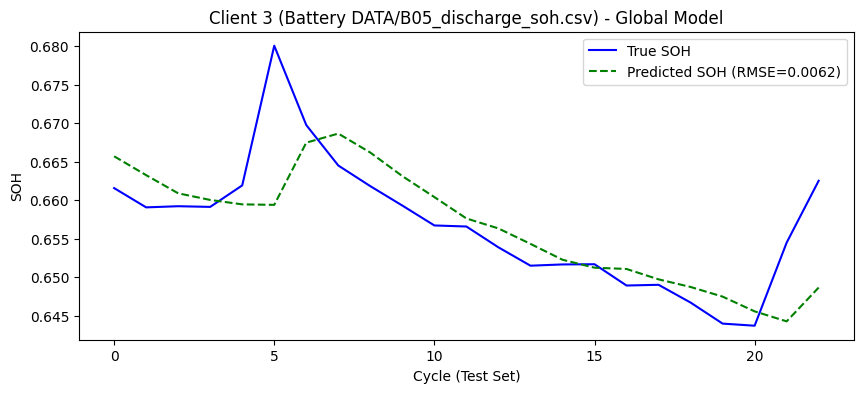

In [4]:

# Plot Global Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_ROUNDS + 1), server.round_losses, marker='o', label='Global Test Loss')
plt.title('Federated Learning - Global Model Convergence')
plt.xlabel('Round')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

# Fine-tuning / Personalization for Client 1 (B48)
# Client 1 has the least data (confirmed: ~23k vs ~40k/50k)
client1 = clients[0] # B48
print(f"\n--- Fine-Tuning for Client {client1.client_id} (B48) ---")
print("Training for 10 additional epochs on local data...")

# Initialize with Global Weights
ft_model = create_model(input_shape)
ft_model.set_weights(server.global_weights)

# Train locally (Fine-tune)
history_ft = ft_model.fit(client1.X_train, client1.y_train, 
                          epochs=10, 
                          batch_size=32, 
                          verbose=1)

print("Fine-tuning completed.")

# Helper to plot prediction
def plot_prediction(model, client, title):
    predicted = model.predict(client.X_test)
    
    # Inverse Transform
    num_samples = len(predicted)
    dummy_pred = np.zeros((num_samples, 9))
    dummy_act = np.zeros((num_samples, 9))
    
    dummy_pred[:, -1] = predicted.flatten()
    dummy_act[:, -1] = client.y_test.flatten()
    
    inv_pred = client.sc.inverse_transform(dummy_pred)[:, -1]
    inv_act = client.sc.inverse_transform(dummy_act)[:, -1]
    
    # Calculate Metrics
    mse = mean_squared_error(inv_act, inv_pred)
    rmse = np.sqrt(mse)
    print(f"{title}")
    print(f"  MSE: {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    
    plt.figure(figsize=(10, 4))
    plt.plot(inv_act, label='True SOH', color='blue')
    plt.plot(inv_pred, label=f'Predicted SOH (RMSE={rmse:.4f})', color='green', linestyle='--')
    plt.title(title)
    plt.xlabel('Cycle (Test Set)')
    plt.ylabel('SOH')
    plt.legend()
    plt.show()

# Plot Client 1 BEFORE Fine-tuning (Global Model)
model_global = create_model(input_shape)
model_global.set_weights(server.global_weights)
plot_prediction(model_global, client1, f'Client {client1.client_id} (B48) - Global Model (Before Fine-Tuning)')

# Plot Client 1 AFTER Fine-tuning (Personalized Model)
plot_prediction(ft_model, client1, f'Client {client1.client_id} (B48) - Personalized Model (After Fine-Tuning)')

# Plot other clients with Global Model
for client in clients[1:]:
    model = create_model(input_shape)
    model.set_weights(server.global_weights)
    plot_prediction(model, client, f'Client {client.client_id} (Battery {client.csv_file}) - Global Model')
